In [1]:
# The first part of this notebook is inspired by R. Labbe's work, the second by A. Bewley's.

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

You should submit before the deadline a **TP_KalmanFilter_firstname-surname.zip** containing:
- The completed .ipynb notebook
- The completed kalman_filter.py, multiple_object_tracker.py and robot_simulation.py files

You do not need to attach the data nor the output of the last section on multiple object tracking as we must be able to regenerate the output by running your notebook.

# Introduction on Gaussian distributions

The Kalman filter is essentially a Bayesian filter that uses Gaussians. Let's see in 1D how we can use Gaussian distributions to encode priors about the location of a robot, and update them given measurements.

## Beliefs as Gaussians

In [2]:
# Code the 1D Gaussian probability density function
def Gaussian_pdf(x, mean=0., variance=1.):
    """
    x: scalar or numpy.array
    Returns N(x|mean,variance), the scalar or numpy array containing the Gaussian pdf evaluated at x.
    """
    y = np.exp(-(x-mean)**2/(2*variance))
    return y

We can express our belief in the robot's position with a Gaussian. Say we believe that the robot is at 10 meters, and the variance in that belief is 1m$^2$, or $\mathcal{N}(10,\, 1)$. A plot of the pdf follows:

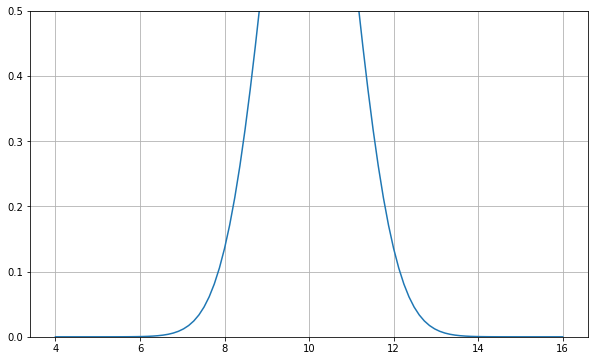

In [3]:
xs = np.linspace(4, 16, 100)
ys = Gaussian_pdf(xs, mean=10.)

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')
plt.ylim(0,.5)
plt.grid(True)

This plot depicts our uncertainty about the robot's position. It represents a fairly inexact belief. While we believe that it is most likely that the robot is at 10 m, any position from 9 m to 11 m or so is quite likely as well.

## Predictions with Gaussians

Suppose starting from an uncertain position $x = \mathcal{N}(10,\, 1)$, the robot moves by an amount $\epsilon = \mathcal{N}(0,\, 0.5^2)$. How do we compute the prior for the new location of the robot, given that both their initial location and move are uncertain?

We make use of the fact that the sum of two independent Gaussians is again Gaussian, whose mean equals the sum of their means and whose variance equals the sum of their variance. In our case, this yields a prior $\bar{x}=\mathcal{N}(\bar\mu,\, \bar\sigma^2)$ with:

$$\begin{aligned}\bar\mu &= \mu_x + \mu_\epsilon = 10 + 0 &&= 10 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{\epsilon}^2 = 1^2 + 0.5^2 &&= 1.25\end{aligned}$$

It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, we don't really know where the robot is moving, so the confidence should get smaller (variance gets larger). $\sigma_{\epsilon}^2$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty.

Let's implement this:

In [4]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [5]:
# Implement the prediction update from above
def predict(pos, movement):
    """
    pos, movement: gaussian namedtuples
    Returns: a gaussian namedtuple
    """
    mean3 = pos.mean + movement.mean
    var3 = pos.var + movement.var
    prior = gaussian(mean3,var3)
    return prior

In [6]:
pos = gaussian(10., 1.**2)
move = gaussian(0, 0.5**2)
predict(pos, move)
#print(pos.var)

𝒩(μ=10.000, 𝜎²=1.250)

The prior states that the robot is at 10 m with a variance of 1.25 m$^2$, which is what we computed by hand.

## Updates with Gaussians

The likelihood is the probability of the measurement given the current state. We can represent measurements as Gaussians. For example, maybe our sensor states that the robot is at 12 m, with a standard deviation of 0.5 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (12, 0.5^2)$.

Both the likelihood and prior are modeled with Gaussians. The update, a.k.a. the posterior, is obtained up to normalization by multiplying these Gaussians. After normalization, the product of these Gaussians is in turn a Gaussian $\mathcal N(\mu, \sigma^2)$ as per slides 44-45.

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &\propto prior \cdot likelihood \\
&= \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \\
&\propto \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

Let's implement this:

In [7]:
# Implement the update obtained by multiplying prior and likelihood as in the formula above
def gaussian_multiply(g1, g2):
    """
    g1, g2: Gaussian namedtuples
    Returns: a Gaussian namedtuple that is (up to renormalization) the product of g1 and g2
    """
    mean1 = g1.mean
    mean2 = g2.mean
    var1 = g1.var
    var2 = g2.var
    mean3 = (var1*mean2+var2*mean1)/(var1+var2)
    var3 = (var1*var2)/(var1+var2)
    product = gaussian(mean3,var3)
    return product

def update(prior, likelihood):
    """
    prior, likelihood: Gaussian namedtuples
    Returns: a Gaussian namedtuple
    """
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [8]:
# Test the update function
predicted_pos = gaussian(10., 1.25)
measured_pos = gaussian(12., 0.5**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=11.667, 𝜎²=0.208)

### Understanding Gaussian multiplication

Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

- La moyenne est la même, donc il n'y aura qu'une seule bosse, par contre, le produit au carré réduira la largeur de la bosse (car valeur inférieur à 1). La moyenne reste 10.

𝒩(μ=10.000, 𝜎²=0.500)


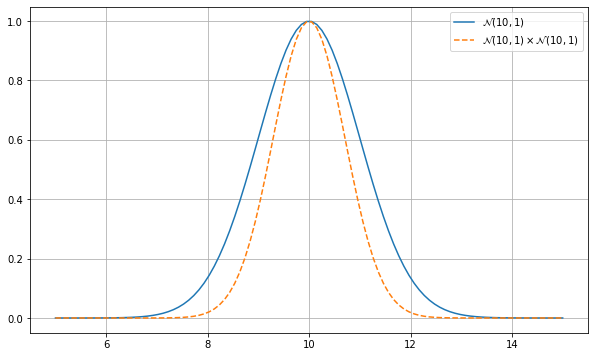

In [9]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)
product = gaussian_multiply(z, z)

plt.figure(figsize=(10, 6))

xs = np.linspace(5, 15, 100)
ys = Gaussian_pdf(xs, z.mean, z.var)
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = Gaussian_pdf(xs, product.mean, product.var)
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
plt.grid(True)

print(product)

The result of the multiplication is taller and narrow than the original Gaussian but the mean is unchanged. Does this match your intuition?

- Yes

Now let's plot the pdf of $\mathcal{N}(10.4,\, 1) \times \mathcal{N}(9.6,\, 1)$. What do you think the result will be?

- Les moyennes sont différentes donc il y aura une bosse au milieu des deux (car produit).

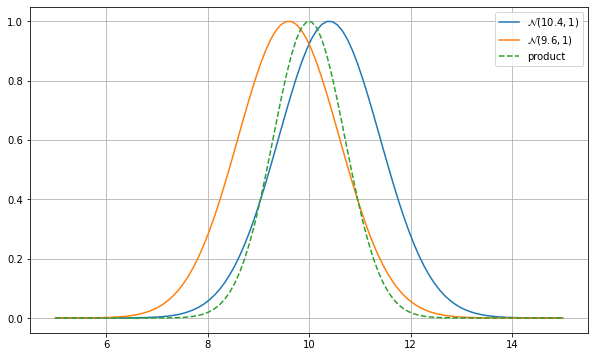

In [10]:
def plot_products(g1, g2): 
    plt.figure(figsize=(10, 6))
    product = gaussian_multiply(g1, g2)

    xs = np.linspace(5, 15, 100)
    ys = Gaussian_pdf(xs, g1.mean, g1.var)
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = Gaussian_pdf(xs, g2.mean, g2.var)
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g2.mean},{g2.var})$')

    ys = Gaussian_pdf(xs, product.mean, product.var)
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    plt.grid(True)
    plt.show()
    
z1 = gaussian(10.4, 1)
z2 = gaussian(9.6, 1)
 
plot_products(z1, z2)

Finally, consider the case where one of the Gaussian distributions is much narrower than the other. Which of the means is closest to the mean of the resulting product distribution? Compare the width of the product Gaussian to the widths of the respective Gaussians forming the product.

- Dans le cas d'une gaussienne plus fine que l'autre, la moyenne résultante sera plus proche de la moyenne de la gaussienne plus large, la gaussienne résultante est plus fine que les gaussiennes multipliées.

# Kalman filter tracking of robot trajectory

We will apply Kalman filtering to track the location of a robot in 1D. The robot moves during each time step and its new location is sensed with some measurement error. We will filter the noisy measurements to track the location over time.

You will assume the robot moves with constant velocity and implement a constant velocity state transition model. The state is thus 2-dimensional and consists of the location $x$ of the robot and its velocity $v$ (similar to slide 17 but in 1D). We assume measurements are acquired at time intervals of $\Delta t=1$s.

You first have to complete the KalmanFilter implementation in kalman_filter.py. It implements a general purpose Kalman filter as per the predict and update equations presented in the slides 47-50.

You then have to complete the code blocks below.

In [11]:
from robot_simulation import RobotSimulation
from kalman_filter import KalmanFilter

In [12]:
# This code generates the (walk and) measurements at each of N timesteps spaced by a time interval of delta_t = 1.0

process_std = .5
measurement_std = 2.
N = 25

robot = RobotSimulation(0, 1.0, measurement_std, process_std)
zs = [np.array([robot.move_and_locate()]) for _ in range(N)] # Array of measurements at each time step

In [13]:
# Initialize the Kalman filter
dim_x = 2
dim_z = 1
kf = KalmanFilter(dim_x,dim_z)

kf.x = np.zeros((dim_x)) # Initialize the location and velocity at 0.
print(np.zeros((dim_x)).T)
kf.P = np.array([[20**2,0],[0,2**2]]) # Initialize the standard deviation of the location at 20. and the std of the velocity at 2.

kf.F = np.eye(dim_x) # Set the transition matrix to that corresponding to a constant velocity model
kf.Q = np.array([[process_std**2,0],[0,0.1**2]]) # Set the process noise std to process_std for the location and 0.1 for the velocity
kf.H = np.array([[1,0]]) # Set the measurement matrix to only observe the location
kf.R = np.array([[measurement_std**2]]) # Set the measurement std to measurement_std

# Run the Kalman filter at each timestep and store the predictions in the arrays below

priors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance
xs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance
vs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance 

xs[0,:] = np.array([kf.x[0],kf.P[0,0]])
vs[0,:] = np.array([kf.x[1],kf.P[1,1]])

for i, z in enumerate(zs):
    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs
    kf.predict()
    priors[i] = np.array([kf.x[0],kf.P[0,0]])
    kf.update(z)
    xs[i+1,:] = np.array([kf.x[0],kf.P[0,0]])
    vs[i+1,:] = np.array([kf.x[1],kf.P[1,1]])
    
    
    

    

[0. 0.]


In [14]:
def plot_filter(xs, var, c='C0', **kwargs):
    ys = xs
    xs = range(len(ys))
    
    lines = plt.plot(xs, ys, color=c, label='Filter', **kwargs)

    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

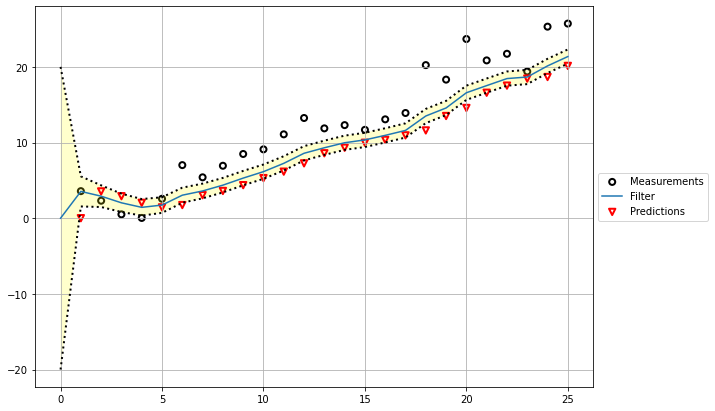

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(range(1,len(zs)+1), zs, edgecolor='k', facecolor='none',
                        lw=2, label='Measurements')
plot_filter(xs[:,0], xs[:,1])
plt.scatter(range(1,len(priors)+1), priors[:,0], marker='v', s=40, edgecolor='r',
                facecolor='None', lw=2, label='Predictions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

What can you say at each timestep of the position of the filtered estimate compared to the position of the measurement and of the prior?

- Each prediction has a small latency compared to the measurements.

Print the standard deviation of the location before (a priori) and after (a posteriori) each measurement. What can you say about it? Compare to the measurement standard deviation.

- A posteriori deviation is smaller than a priori deviation which is normal because both of them decrease but a posteriori is just in advance of one step from a priori. Measurement standard deviation is on contrary constant because standard deviation on measurement was supposed constant from the beginning is bigger than prediction std. 

In [28]:
# Initialize the Kalman filter
dim_x = 2
dim_z = 1
kf = KalmanFilter(dim_x,dim_z)

kf.x = np.zeros((dim_x)) # Initialize the location and velocity at 0.
print(np.zeros((dim_x)).T)
kf.P = np.array([[20**2,0],[0,2**2]]) # Initialize the standard deviation of the location at 20. and the std of the velocity at 2.

kf.F = np.eye(dim_x) # Set the transition matrix to that corresponding to a constant velocity model
kf.Q = np.array([[process_std**2,0],[0,0.1**2]]) # Set the process noise std to process_std for the location and 0.1 for the velocity
kf.H = np.array([[1,0]]) # Set the measurement matrix to only observe the location
kf.R = np.array([[measurement_std**2]]) # Set the measurement std to measurement_std

# Run the Kalman filter at each timestep and store the predictions in the arrays below

priors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance
xs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance
vs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance 

xs[0,:] = np.array([kf.x[0],kf.P[0,0]])
vs[0,:] = np.array([kf.x[1],kf.P[1,1]])

for i, z in enumerate(zs):
    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs
    kf.predict()
    priors[i] = np.array([kf.x[0],kf.P[0,0]])
    kf.update(z)
    xs[i+1,:] = np.array([kf.x[0],kf.P[0,0]])
    vs[i+1,:] = np.array([kf.x[1],kf.P[1,1]])

[0. 0.]


In [29]:
"""
priors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance
xs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance
vs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance 

xs[0,:] = [kf.x[0], kf.P[0,0]]
vs[0,:] = [kf.x[1], kf.P[1,1]]

for i, z in enumerate(zs):
    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs
    kf.predict() # predicting
    xs[i+1,:] = [kf.x[0], kf.P[0,0]]
    kf.update(np.array(z)) # measuring
    priors[i,:] = kf.x
    vs[i+1,:] = [kf.x[1], kf.P[1,1]]
"""

'\npriors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance\nxs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance\nvs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance \n\nxs[0,:] = [kf.x[0], kf.P[0,0]]\nvs[0,:] = [kf.x[1], kf.P[1,1]]\n\nfor i, z in enumerate(zs):\n    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs\n    kf.predict() # predicting\n    xs[i+1,:] = [kf.x[0], kf.P[0,0]]\n    kf.update(np.array(z)) # measuring\n    priors[i,:] = kf.x\n    vs[i+1,:] = [kf.x[1], kf.P[1,1]]\n'

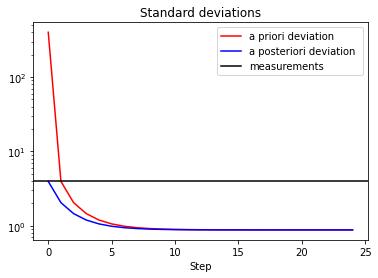

In [30]:
plt.figure()
plt.title('Standard deviations')
plt.yscale('log')
plt.xlabel('Step')
plt.plot(xs[:-1,1], label = 'a priori deviation', color = 'r')
plt.plot(xs[1:,1], label = 'a posteriori deviation ', color = 'b')
plt.axhline(y = kf.R, label = 'measurements' , color = 'k')
plt.legend()
plt.show()

The robot model implemented in RobotSimulation is very close to the constant velocity model that we assume in the Kalman filter. As a variant, generate the walk according to a different robot model than the one proposed in RobotSimulation (for instance any function of time). Does the Kalman filter still behave adequately? If not, what could you change to improve its behaviour?

- The Kalman filter doesn't work as well as soon as we add a function implying non-constant velocity model, this can be adressed by adding the data of acceleration in the state vector, because acceleration is no longer null, this will help prediction predicting acceleration.

# Multiple Object Tracking

We now turn to multiple object tracking of pedestrians in video input, using the framework of tracking-by-detection as proposed in "Simple Online and Realtime Tracking" (Bewley et al., IEEE ICIP 2016). The gist of the framework is explained in slides 57-62.

On each new frame, a pedestrian detector is run to find the frame detections. Each detection is associated to an existing track, and new tracks are created for unmatched detections (unmatched tracks are deleted after a few frames without a match). Each individual track is maintained and updated by a Kalman filter.

In tracking-by-detection, object detectors are typically deep learning models. In this practical work, we will assume for convenience that detections are given to us rather than implementing or running a DL model. These are the columns 3 to 7 in the file 'data/KITTI-17_det.txt', where detection bounding boxes are in the format $[x1,y1,w,h]$, with $x1,y1$ the coordinates of the left-top corner, $w$ the width of the box and $h$ the height.

You can visualize what detections look like by opening the video 'data/KITTI-17_detections.webm' (you do not need this file in the remaining of the practical work).

The code presented here implements the other steps of track prediction, data association and track update. In this version, the Kalman filter maintains the bounding box in the form of the bounding box center coordinates $x,y$, the bounding box area $s$ (width$\times$height), and the aspect ration $r$ (width/height). In addition a constant velocity model is used on $x,y,s$ ($r$ is supposed constant). Therefore the internal state is 7-dimensional $[x,y,s,r,\dot{x},\dot{y},\dot{s}]$. As only the box location is measured, the noisy measurement is 4-dimensional: $[x,y,s,r]$.

We will reuse the Kalman filter that you have implemented in the previous part. Before running the cells below, you will have to fill in the missing lines in multiple_object_tracker.py:
- In iou_batch, implement the intersection-over-union of detected and tracked bounding boxes
- In convert_bbox_to_z and convert_x_to_bbox, fill in the missing lines
- In KalmanBoxTracker, fill in the missing parts in the init, predict and update member functions

You can test your iou_batch implementation using the cell below before running the multi-object tracker. After running the MOT, video frames with superimposed bounding boxes from tracked pedestrians are saved in 'output/images'. The last block of code uses opencv to convert these frames into a video saved in 'output/video.avi' for better visualization.

Optionally, you can test your code with a second video with detection file 'data/KITTI-13_det.txt' and frames in 'data/KITTI-13_img'

In [16]:
import numpy as np

from multiple_object_tracker import MOT
from multiple_object_tracker import iou_batch

In [17]:
# To test your implementation of iou_batch
bb_test = np.array([[0,0,30,30],
                    [15,15,45,45]])
bb_gt = np.array([[0,0,30,30],
                  [15,15,45,45],
                  [30,30,60,60]])

iou_batch(bb_test, bb_gt)

# Output should be
# [[1, 1/7, 0],
#  [1/7, 1, 1/7]]

array([[0.5  , 0.125, 0.   ],
       [0.5  , 0.5  , 0.125]])

Multiple Object Tracker on the video frames from 'data/KITTI-17_img':

In [18]:
import os
from skimage import io

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [19]:
colours = np.random.rand(32, 3)
dets_filename = 'data/KITTI-17_det.txt'
img_path = os.path.join('data', 'KITTI-17_img')

if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/images'):
    os.makedirs('output/images')

[927.02668656]
[1080.69063248]
[1117.24077168]
[950.605804]


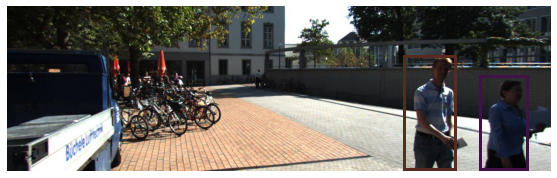

In [20]:
# Initialize the multi object tracker
mot_tracker = MOT(max_age=1, min_hits=3, iou_threshold=0.3)

# Load all detections for all frames
dets = np.loadtxt(dets_filename, delimiter=',')

# Run the MOT over all frames, save png of all frames with tracked pedestrians
for frame in range(int(dets[:,0].max())):
    frame += 1 #detection and frame numbers begin at 1
    frame_dets = dets[dets[:, 0]==frame, 2:7]
    frame_dets[:, 2:4] += frame_dets[:, 0:2] #convert from [x1,y1,w,h] to [x1,y1,x2,y2]
    
    im = io.imread(os.path.join(img_path, '%06d.jpg'%(frame)))
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 10*im.shape[0]/im.shape[1]))
    ax1 = fig.add_subplot(111, aspect='equal')   
    ax1.imshow(im)   
    plt.grid(False)
    plt.axis('off')
    
    trackers = mot_tracker.update(frame_dets)
    
    for d in trackers:
        d = d.astype(np.int32)
        ax1.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colours[d[4]%32,:]))

    plt.savefig(os.path.join('output', 'images', str(frame).zfill(6) + '.png'))
    plt.show();

In [21]:
# Reload the png's and save as video for better visualization
import os
import cv2

image_folder = os.path.join('output', 'images')
video_name = os.path.join('output','video.avi')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

Optionally, you can test your code with a second video with detection file in 'data/KITTI-13_det.txt' and frames in 'data/KITTI-13_img'